In [1]:
import os
import re
import ast
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from glob import glob
from scipy.stats import ttest_1samp
import scikit_posthocs as sp
from typing import defaultdict
from scipy import stats
from cycler import cycle
from scipy.stats import ttest_ind, t

In [18]:
GOOD_RMSE = 0.7

In [2]:
def extract_dicts(filepath):
    with open(filepath, "r") as f:
        text = f.read()
    
    dicts = []
    start = 0
    while True:
        start_idx = text.find("results_dict =", start)
        if start_idx == -1:
            break
        brace_idx = text.find("{", start_idx)
        if brace_idx == -1:
            break

        brace_count = 0
        end_idx = brace_idx
        while end_idx < len(text):
            if text[end_idx] == "{":
                brace_count += 1
            elif text[end_idx] == "}":
                brace_count -= 1
                if brace_count == 0:
                    break
            end_idx += 1
        
        dict_text = text[brace_idx:end_idx+1]
        parsed_dict = ast.literal_eval(dict_text)
        dicts.append(parsed_dict)
        start = end_idx + 1

    return dicts

# Read all markdown files
results = []

for filepath in glob("*.md"):
    model_name = os.path.splitext(os.path.basename(filepath))[0]
    dicts = extract_dicts(filepath)
    for d in dicts:
        for benchmark, subtasks in d.items():
            for subtask, score in subtasks.items():
                results.append({
                    "model": model_name,
                    "benchmark": benchmark,
                    "subtask": subtask,
                    "score": score
                })

# Create DataFrame
df = pd.DataFrame(results)

df


,model,benchmark,subtask,score
0,ChemProp Pretrained,CHEMBL1862_Ki,cliff,0.685876
1,ChemProp Pretrained,CHEMBL1862_Ki,noncliff,0.759236
2,ChemProp Pretrained,CHEMBL1871_Ki,cliff,0.859640
3,ChemProp Pretrained,CHEMBL1871_Ki,noncliff,0.486996
4,ChemProp Pretrained,CHEMBL2034_Ki,cliff,0.854848
...,...,...,...,...
895,ChemProp Direct,CHEMBL4203_Ki,noncliff,0.946484
896,ChemProp Direct,CHEMBL4616_EC50,cliff,0.786475
897,ChemProp Direct,CHEMBL4616_EC50,noncliff,0.843974
898,ChemProp Direct,CHEMBL4792_Ki,cliff,0.785837


In [3]:
size_dict = {}
for benchmark_name in df["benchmark"].unique():
    bench_df = pd.read_csv(f"https://raw.githubusercontent.com/molML/MoleculeACE/7e6de0bd2968c56589c580f2a397f01c531ede26/MoleculeACE/Data/benchmark_data/{benchmark_name}.csv")
    test_df = bench_df[bench_df["split"] == "test"]
    size_dict[benchmark_name] = dict(
        cliff=len(test_df[test_df["cliff_mol"] == 1]),
        noncliff=len(test_df[test_df["cliff_mol"] == 0]),
    )

In [4]:
df["n_mols"] = df.apply(lambda row: size_dict[row['benchmark']][row['subtask']], axis=1)

In [5]:
df["benchmark"] = df["benchmark"].map(lambda s: s.split("_")[0].replace("CHEMBL", ""))

In [6]:
df

,model,benchmark,subtask,score,n_mols
0,ChemProp Pretrained,1862,cliff,0.685876,67
1,ChemProp Pretrained,1862,noncliff,0.759236,94
2,ChemProp Pretrained,1871,cliff,0.859640,32
3,ChemProp Pretrained,1871,noncliff,0.486996,102
4,ChemProp Pretrained,2034,cliff,0.854848,52
...,...,...,...,...,...
895,ChemProp Direct,4203,noncliff,0.946484,136
896,ChemProp Direct,4616,cliff,0.786475,73
897,ChemProp Direct,4616,noncliff,0.843974,66
898,ChemProp Direct,4792,cliff,0.785837,160


Number of nonsignificant differences per model:
model
ChemProp Direct        8
ChemProp Pretrained    3
RF Morgan              1
Name: same, dtype: int64
Rate (%) of nonsignificant differences per model:
model
ChemProp Direct        27.6
ChemProp Pretrained    10.3
RF Morgan               3.4
Name: same, dtype: float64


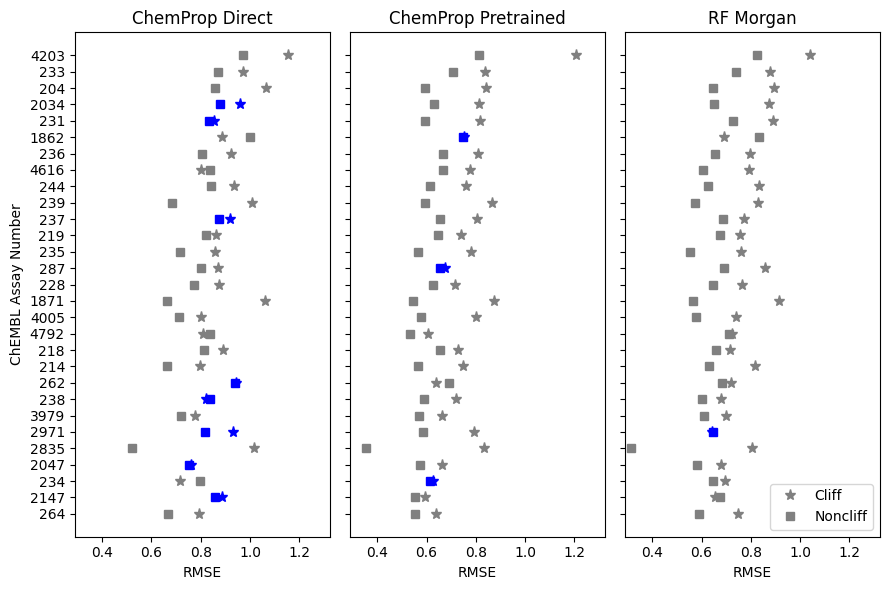

In [7]:
order = (df.groupby("benchmark")["score"]
           .median()
           .sort_values(ascending=True)
           .index)

pvals = []
results = []
alpha = 0.05
min_rmse = df["score"].min()*0.95
max_rmse = df["score"].max()*1.05
for (model, benchmark), group in df.groupby(['model', 'benchmark']):
    cliff_scores = group[group['subtask'] == 'cliff']['score']
    noncliff_scores = group[group['subtask'] == 'noncliff']['score']
    ttest_result = ttest_ind(cliff_scores, noncliff_scores, equal_var=False)
    pvals.append((model, benchmark, ttest_result.pvalue > alpha))
    cliff_mean = cliff_scores.mean()
    noncliff_mean = noncliff_scores.mean()
    results.append(
        {
            'model': model,
            'benchmark': benchmark,
            'cliff': cliff_mean,
            'noncliff': noncliff_mean,
        }
    )

pvals = pd.DataFrame(pvals, columns=['model', 'benchmark', 'same'])
nonsignificant = pvals.groupby('model')['same'].sum()

print("Number of nonsignificant differences per model:")
print(nonsignificant)

print("Rate (%) of nonsignificant differences per model:")
print((nonsignificant / len(df["benchmark"].unique()) * 100).round(1))

res_df = pd.DataFrame(results)
res_df = res_df.merge(pvals, on=['model', 'benchmark'])
res_df = res_df.set_index("benchmark")

fig, axes = plt.subplots(1, res_df['model'].nunique(), figsize=(3 * res_df['model'].nunique(), 6), sharex=True, sharey=True)

for ax, (model, data) in zip(axes, res_df.groupby('model')):
    for benchmark, row in data.loc[order].iterrows():
        color = 'blue' if row['same'] else 'grey'
        ax.errorbar(row['cliff'], benchmark, fmt='*', markersize=8, color=color, markeredgecolor=color)
        ax.errorbar(row['noncliff'], benchmark, fmt='s', markersize=6, color=color, markeredgecolor=color)
    ax.set_title(model)
    ax.set_xlim(min_rmse, max_rmse)
    ax.set_xlabel('RMSE')
    ax.set_yticks([])
ax = axes[0]
ax.set_yticks(range(len(df["benchmark"].unique())))
ax.set_ylabel('ChEMBL Assay Number')
ax = axes[-1]
ax.legend(['Cliff', 'Noncliff'], loc='lower right')

plt.tight_layout()
plt.show()


In [8]:
# iterate over pairs of the df to calculate the differences
records = []
for i, (model, model_df) in enumerate(df.groupby("model", sort=False)):
    for j, (benchmark, bench_df) in enumerate(model_df.groupby("benchmark", sort=False)):
        for k in range(0, len(bench_df), 2):
            records.append(
                dict(
                    model=model,
                    benchmark=benchmark,
                    diff=bench_df["score"].iloc[k] - bench_df["score"].iloc[k+1],
                    avg=(bench_df["n_mols"].iloc[k] * bench_df["score"].iloc[k] + bench_df["n_mols"].iloc[k + 1] * bench_df["score"].iloc[k+1]) / (bench_df["n_mols"].iloc[k] + bench_df["n_mols"].iloc[k + 1]),
                )
            )
df_2 = pd.DataFrame.from_dict(records)

In [9]:
df_2

,model,benchmark,diff,avg
0,ChemProp Pretrained,1862,-0.073360,0.728708
1,ChemProp Pretrained,1862,0.003172,0.773882
2,ChemProp Pretrained,1862,0.027290,0.767012
3,ChemProp Pretrained,1862,-0.029367,0.709411
4,ChemProp Pretrained,1862,0.085707,0.777132
...,...,...,...,...
445,ChemProp Direct,4792,-0.026121,0.834436
446,ChemProp Direct,4792,-0.015429,0.833447
447,ChemProp Direct,4792,-0.032929,0.816225
448,ChemProp Direct,4792,-0.006521,0.823080


In [10]:
win_tracker = defaultdict(int)

n_benchmarks = len(df_2["benchmark"].unique())
alpha = 0.05
xerr_dict = {}
for i, (model, model_df) in enumerate(df_2.groupby("model", sort=False)):
    xerr_dict[model] = {}
    for j, (benchmark, bench_df) in enumerate(model_df.groupby("benchmark", sort=False)):
        result = ttest_1samp(bench_df["diff"], 0.0, alternative="greater")
        xerr_dict[model][benchmark] = abs(result.confidence_interval(1 - alpha).low - bench_df["diff"].mean())
        if result.pvalue < alpha:
            ...  # mean is practically less than zero
        else:
            win_tracker[model] += 1

results = pd.DataFrame.from_records(
    [{
        "Model": model.replace("_", " "),
        "Consistent Count": win_count,
        "Consistency Rate (%)": 100 * win_count / n_benchmarks,
    } for model, win_count in win_tracker.items()
    ], index="Model").sort_values(by="Consistency Rate (%)", axis=0, ascending=False)
results.round(1)



,Consistent Count,Consistency Rate (%)
Model,,
ChemProp Direct,9,31.0
ChemProp Pretrained,4,13.8
RF Morgan,3,10.3


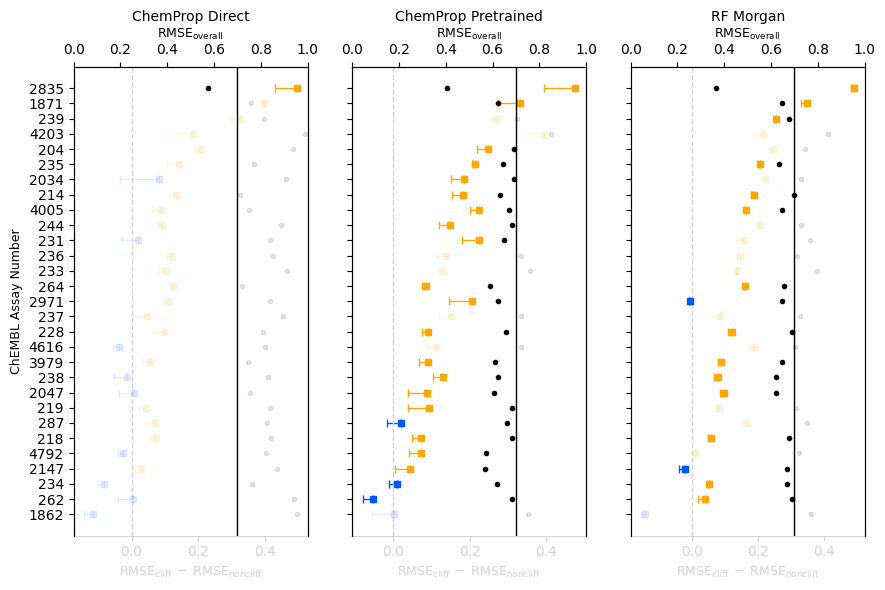

In [20]:
order = (df_2.groupby("benchmark")["diff"]
           .median()
           .sort_values(ascending=True)
           .index)
y_pos = np.arange(len(order))

models  = sorted(df_2["model"].unique())
n_models = len(models)
fig, axes = plt.subplots(1, n_models,
                         figsize=(3*n_models, 6),
                         sharey=True)

min_diff = df_2["diff"].min()*0.95
max_diff = df_2["diff"].max()*1.05
for i, (ax, mod) in enumerate(zip(axes, models)):
    sub = df_2[df_2["model"] == mod]
    means = sub.groupby("benchmark")["diff"].mean()[order]

    avg_errors = sub.groupby("benchmark")["avg"].mean()[order]
    
    # Primary axis (diff)
    for j in range(means.shape[0]):
        bmark = means.index[j]
        avg_error = avg_errors[bmark]
        if avg_error > GOOD_RMSE:
            alpha = 0.1
        else:
            alpha = 1.0
        ax.errorbar(means[bmark], y_pos[j],
                    xerr=np.array([[xerr_dict[mod][bmark], 0]]).T,
                    markersize=4, capsize=3, lw=1, marker='s',
                    color=("#0056FF", alpha) if (means[bmark] - xerr_dict[mod][bmark]) <= 0.0 else ("#FFA900", alpha)
        )
    
    # Secondary axis (avg_error)
    ax2 = ax.twiny()
    for j in range(avg_errors.shape[0]):
        bmark = avg_errors.index[j]
        avg_error = min(avg_errors[bmark], 1.0)  # Cap values > 1
        if avg_error > GOOD_RMSE:
            alpha = 0.1
        else:
            alpha = 1.0
        ax2.plot(avg_error, y_pos[j], marker='o', markersize=3, 
                 color=("k", alpha), linestyle='none')
        # Add marker for overflow values
        if avg_errors[bmark] > 1.0:
            ax2.plot(1.0, y_pos[j], marker='>', markersize=5, 
                     color=("k", alpha), linestyle='none')
    
    ax.axvline(0, color="lightgrey", lw=1, linestyle='--')
    ax2.axvline(GOOD_RMSE, color="k", lw=1, linestyle='-')
    ax.set_title(mod, fontsize=10, pad=4)
    ax.set_xlabel(r"$\mathrm{RMSE_{cliff}\;-\;RMSE_{noncliff}}$", fontsize=9, color="lightgrey")
    ax2.set_xlabel("$\mathrm{RMSE_{overall}}$", fontsize=9, color='k')
    ax2.tick_params(axis='x', colors='k')
    ax.spines['bottom'].set_color('lightgrey')
    ax.tick_params(axis='x', which='both',
               color='lightgrey',
               labelcolor='lightgrey')
    ax2.spines['bottom'].set_visible(False)
    ax2.set_xlim(0, 1)
    
    if i == 0:
        ax.set_yticks(y_pos)
        ax.set_yticklabels(order.to_list())
        ax.set_ylabel("ChEMBL Assay Number", fontsize=9)

plt.tight_layout(w_pad=1)
plt.show()